Imports

In [25]:
from data_translator import TestTranslator, EncodeForGA, GAToScheduleTranslator
from hybrid_solution_data_loader import get_data
from models import Order, SimulationEnvironment
from solver import GASolver
from visualize import visualize_schedule
import objective_function

Read from Source

In [26]:
n_workstations, recipes, operation_times = get_data(0)
recipies, workstations, resources, tasks, _ = TestTranslator().translate(n_workstations, recipes, operation_times)

env = SimulationEnvironment(workstations, tasks, resources, recipies)

Create Orders

In [27]:
earliest_slot = 0
last_slot = 100
recipe_orders = [0, 1, 2, 3, 0, 3, 2, 1, 0, 3] # for dataset 0
orders = []
o_id = 0
for order in recipe_orders:
    orders.append(Order(o_id, 0, 1000, last_slot, [order], 100, 50, False, 0, False, 500)) # for now: use resources to select recipe
    o_id = o_id + 1


Translate for Solver

In [28]:
# translate datamodel to encoding
encoder = EncodeForGA()
# TODO: alternatives can be completely removed (TEST first)
values, durations, all_jobs, alternatives = encoder.translate(env, orders) # encoding, duration lookup table, list of all jobs used (probably not needed), possible alternatives for each job
# value encoding for GA: <workstation, start time>, could possibly just be <workstation>
print(values)
print(all_jobs)
print(durations)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 10, 11, 6, 7, 8, 9, 3, 4, 5, 0, 1, 2, 10, 11]
{0: [2, 5, 4, 1, 2], 1: [5, 4, 5, 7, 5], 2: [4, 5, 5, 4, 5], 3: [2, 5, 4, 1, 2], 4: [5, 4, 5, 7, 5], 5: [4, 5, 5, 4, 5], 6: [2, 5, 4, 1, 2], 7: [5, 4, 5, 7, 5], 8: [4, 5, 5, 4, 5], 9: [2, 5, 4, 7, 8], 10: [2, 5, 4, 1, 2], 11: [5, 4, 5, 7, 5]}


Run Solver

In [29]:
# create solver object
solver = GASolver(values, durations, all_jobs, alternatives, env, orders)
solver.initialize(earliest_slot, last_slot, 100, 50, max_generations=5000)
solver.run()

Done


Result Output

In [30]:
result = solver.get_best()
selected_tasks = solver.get_result_jobs() # selected task alternatives
fitness = solver.get_best_fitness()
print("Parameters of the best solution : {solution}".format(solution=result))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(fitness)))
fitness_history = solver.assignments_best
average_fitness_history = solver.average_assignments


Parameters of the best solution : [ 2 53  0 50  1 49  4 52  1 53  2 50  2 54  1 53  2 50  1 51  1 48  4 48
  4 52  2 47  3 51  0 56  0 53  3 53  4 52  4 53  0 47  4 52  2 53  3 49
  4 55  3 49  3 53  2 47  2 47]
Fitness value of the best solution = 211


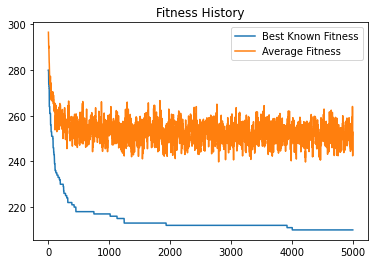

In [31]:
import matplotlib.pyplot as plt
x = list(range(0, len(fitness_history)))
plt.plot(x, fitness_history)
plt.plot(x, average_fitness_history)
plt.title('Fitness History')
plt.legend(['Best Known Fitness', 'Average Fitness'])
plt.xlabel = 'Generation'
plt.ylabel = 'Fitness'
plt.show()

(Optional) Postprocessing

Translate to Schedule

In [32]:
schedule = GAToScheduleTranslator().translate(result, selected_tasks, env, orders)
"""for workstation in schedule.assignments:
    for assignment in schedule.assignments[workstation]:
        print(f'Workstation: {workstation}, Task: {assignment[0]}, Start Time: {assignment[1]}, Duration: {durations[assignment[0]][workstation]}')"""
visualize_schedule(schedule, env, orders)

Evaluate Schedule

In [33]:
#NOTE: the objective functions in this case assume the solution is feasible, not additional checks
# TODO: all fitness function using the get_last function are currently broken
makespan, tardiness, deviation, idle_time, profit = objective_function.calculate_comparison_values(schedule, orders, env)
print(f'Fitness Values:\nMakespane: {makespan}\nTardiness: {tardiness}\nDeviation: {deviation}\nIdle Time: {idle_time}\nProfit: {profit}')

Fitness Values:
Makespane: 11
Tardiness: inf
Deviation: inf
Idle Time: 170
Profit: inf
